# 3.2 线性回归的从零开始实现

## 3.2.1 生成数据集
- 根据带有噪声的线性模型构造一个人造数据集，使用这个有限样本的数据集来恢复这个模型的参数。我们使用线性模型参数$w=[2,-3.4]^{T}$、$b=4.2$和噪声项$\epsilon$生成数据集及其标签：$y=Xw+b+\epsilon$
- 生成一个包含1000个样本的数据集， 每个样本包含从标准正态分布中采样的2个特征。


In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

# 生成 y = Xw+b+噪声
def synthetic_data(w, b, num_examples): #@save
    # 生成均值为0,方差为1的样本矩阵，样本数（行数）为num_examples，列数为len(w)
    X = torch.normal(0,1,(num_examples, len(w)))

    # 计算矩阵X和w的乘积+b
    y = torch.matmul(X,w)+b

    # 添加噪声，均值为0,方差为0.01,形状与y相同
    y += torch.normal(0, 0.01 , y.shape)

    # 将X与y变成列向量后返回
    return X,y.reshape((-1,1))

true_w = torch.tensor([2,-3.4])
true_b = 4.2


# features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）。
features,labels = synthetic_data(true_w,true_b,1000)  # 生成特征与标注

print('features:',features[0],'\nlabel:',labels[0])


features: tensor([-0.4340, -0.5067]) 
label: tensor([5.0611])


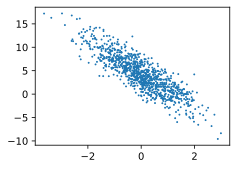

In [2]:

# 通过生成第二个特征features[:, 1]和labels的散点图， 可以直观观察到两者之间的线性关系。
d2l.set_figsize()

# 使用detach转到numpy
d2l.plt.scatter(features[:,(1)].numpy(),
                labels.detach().numpy(),1)

## 3.2.2 读取数据集
- 训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型
- 有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。

In [3]:
"""
在下面的代码中，我们定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。
"""

def data_iter(batch_size,features,labels):
    num_examples = len(features)  # 样本数量

    indices = list(range(num_examples))  # 生成样本的下标

    random.shuffle(indices)  # 这些样本是随机读取的，没有特定的顺序

    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]
        )
        # yield就是 return 返回一个值，并且记住这个返回的位置，下次迭代就从这个位置后开始
        yield features[batch_indices],labels[batch_indices]

"""
通常，我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多。
"""

"""
我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等。
"""
batch_size=10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break


tensor([[ 0.2823,  0.9660],
        [-0.0852, -0.4599],
        [ 0.4435,  0.8698],
        [-0.0333,  0.7479],
        [-1.5489,  0.5616],
        [-0.6506,  0.8909],
        [-0.7471,  1.0627],
        [-0.7955, -2.5540],
        [ 0.4738, -0.8699],
        [ 1.9237, -1.2858]]) 
 tensor([[ 1.4665],
        [ 5.5953],
        [ 2.1370],
        [ 1.5946],
        [-0.7994],
        [-0.1224],
        [-0.9058],
        [11.2913],
        [ 8.1102],
        [12.4308]])


## 3.2.3 初始化模型参数
- 在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数

In [11]:
"""
在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重， 并将偏置初始化为0
"""

"""
在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。 每次更新都需要计算损失函数关于模型参数的梯度。 有了这个梯度，我们就可以向减小损失的方向更新每个参数。
"""

# 权重w设为均值为0,方差为1的正态分布
w=torch.normal(0,0.01,size=(2,1),requires_grad=True)

# b为0
b=torch.zeros(1,requires_grad=True)

w,b


(tensor([[ 0.0275],
         [-0.0089]], requires_grad=True),
 tensor([0.], requires_grad=True))

## 3.2.4 定义模型
- 定义模型，将模型的输入和参数同模型的输出关联起来

In [5]:
def linreg(X,w,b):  #@save
    """线性回归模型"""
    return torch.matmul(X,w)+b

## 3.2.5 定义损失函数
- 平方损失函数
- 在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同

In [6]:
def squared_loss(y_hat,y):  #@save
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2 / 2

## 3.2.6 定义优化算法
小批量随机梯度下降
- 在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。 接下来，朝着减少损失的方向更新我们的参数。

In [7]:
"""
下面的函数实现小批量随机梯度下降更新。 该函数接受模型参数集合、学习速率和批量大小作为输入。

每一步更新的大小由学习速率lr决定。 因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size）来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。
"""

def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad/batch_size  # 求batch_size梯度的均值
            param.grad.zero_()  # 梯度清零，下一次计算梯度时，与上一次无关


## 3.2.7 训练
在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法sgd来更新模型参数。

- 初始化参数
- 重复以下训练，直到完成
  - 计算梯度$\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
  - 更新参数$(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$


在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集，并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。

In [8]:
lr = 0.03
num_epochs = 10  # 整个数据扫10遍
net = linreg
loss = squared_loss

"""
训练过程：两层for-loop

第一层：每一次对数据扫一遍

第二层：拿出批量大小的X，y
"""
for epoch in range(num_epochs):

    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b), y)  # x和y的小批量损失
        # 因为l形状是(batch_size,1),而不是一个标量。l中的所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()  # 反向传播算法一定要是一个标量才能进行计算。
        sgd([w,b],lr,batch_size)  # 使用参数的梯度更新参数

    # 对数据扫完一遍之后，评价下精度
    with torch.no_grad():  # 若没有这个条件，在一个epoch里会输出很多，因为要计算到torch.no_grad()这个条件
        train_l = loss(net(features,w,b),labels)  # 将整个数据传进去，计算损失
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.034391
epoch 2, loss 0.000117
epoch 3, loss 0.000050
epoch 4, loss 0.000050
epoch 5, loss 0.000050
epoch 6, loss 0.000050
epoch 7, loss 0.000050
epoch 8, loss 0.000050
epoch 9, loss 0.000050
epoch 10, loss 0.000050


In [9]:
"""
因为我们使用的是自己合成的数据集，所以我们知道真正的参数是什么。 因此，我们可以通过比较真实参数和通过训练学到的参数来评估训练的成功程度。 事实上，真实参数和通过训练学到的参数确实非常接近。
"""

print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')

w的估计误差：tensor([ 0.0001, -0.0005], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0004], grad_fn=<RsubBackward1>)


## 3.2.8 小结
- 我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。

- 这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。